In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'

extracted_features_dir = "extracted_features/"
model_name = "DenseNet201_512"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448


In [5]:
output_classes = 4
batch_size = 32
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 200

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)

train samples: 4608
test samples: 1792


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 108
predict_size_validation: 36

 num_classes: 4


In [8]:
bottleneck_final_model = applications.DenseNet201(include_top=False, weights='imagenet', pooling='avg')

In [9]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 1792 images belonging to 4 classes.


In [12]:
nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

nb_test_samples: 1792
predict_size_test: 56


In [13]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [14]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [16]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3456 samples, validate on 1152 samples
Epoch 1/70
 - 3s - loss: 1.6500 - acc: 0.2494 - val_loss: 1.3504 - val_acc: 0.3620
Epoch 2/70
 - 0s - loss: 1.4776 - acc: 0.3044 - val_loss: 1.2410 - val_acc: 0.4653
Epoch 3/70
 - 0s - loss: 1.3328 - acc: 0.3874 - val_loss: 1.1562 - val_acc: 0.5477
Epoch 4/70
 - 0s - loss: 1.2653 - acc: 0.4300 - val_loss: 1.0892 - val_acc: 0.6094
Epoch 5/70
 - 0s - loss: 1.1871 - acc: 0.4835 - val_loss: 1.0347 - val_acc: 0.6424
Epoch 6/70
 - 0s - loss: 1.1111 - acc: 0.5194 - val_loss: 0.9901 - val_acc: 0.6606
Epoch 7/70
 - 0s - loss: 1.0717 - acc: 0.5524 - val_loss: 0.9505 - val_acc: 0.6840
Epoch 8/70
 - 0s - loss: 1.0284 - acc: 0.5819 - val_loss: 0.9186 - val_acc: 0.7057
Epoch 9/70
 - 1s - loss: 1.0017 - acc: 0.5828 - val_loss: 0.8898 - val_acc: 0.7144
Epoch 10/70
 - 0s - loss: 0.9788 - acc: 0.6126 - val_loss: 0.8656 - val_acc: 0.7274
Epoch 11/70
 - 0s - loss: 0.9371 - acc: 0.6331 - val_loss: 0.8430 - val_acc: 0.7283
Epoch 12/70
 - 0s - loss: 0.9099 - ac

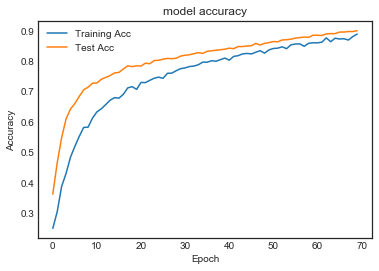

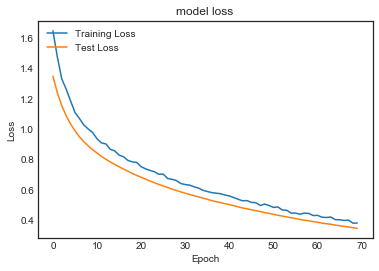

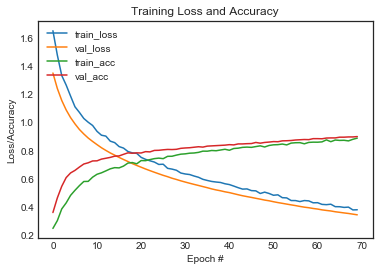

In [17]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 79us/step
Validation Accuracy: 90.0174%
Validation Loss: 0.3457525171753433


In [19]:
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8381696428571429


Confusion Matrix
[[400  33  11   4]
 [ 72 343  17  16]
 [ 34  18 396   0]
 [ 79   1   5 363]]


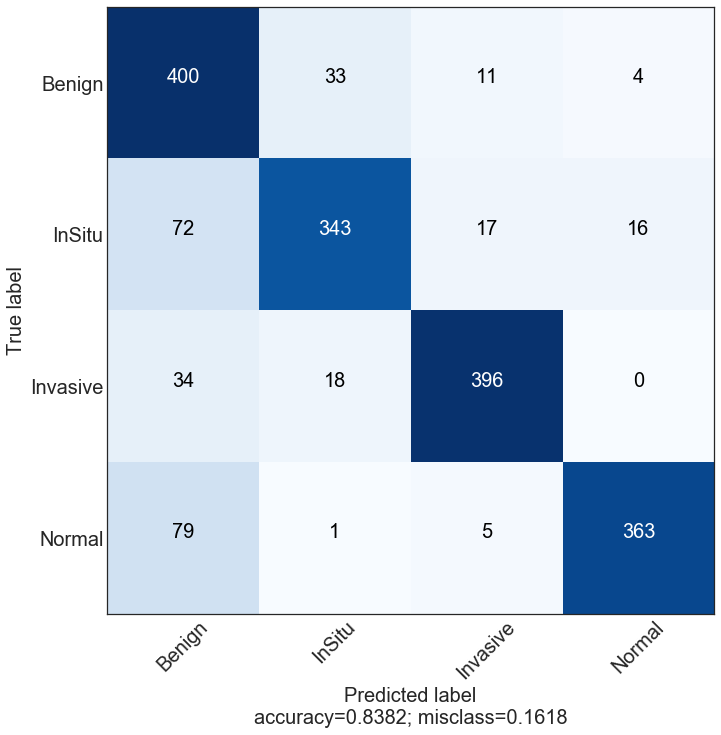

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[400  33  11   4]
 [ 72 343  17  16]
 [ 34  18 396   0]
 [ 79   1   5 363]]
              precision    recall  f1-score   support

      Benign       0.68      0.89      0.77       448
      Normal       0.87      0.77      0.81       448
      InSitu       0.92      0.88      0.90       448
    Invasive       0.95      0.81      0.87       448

   micro avg       0.84      0.84      0.84      1792
   macro avg       0.86      0.84      0.84      1792
weighted avg       0.86      0.84      0.84      1792



In [23]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  84.7457627118644
Specificity :  91.22340425531915


____
# test without augmentation

In [24]:
test_dir_whithout_aug = "data/512/test-without-aug/"
test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

print("nb_test_samples:", nb_test_without_aug_samples)
print("predict_size_test:", predict_size_test_without_aug)

Found 112 images belonging to 4 classes.
nb_test_samples: 112
predict_size_test: 4


In [25]:
bottleneck_features_test_without_aug = bottleneck_final_model.predict_generator(test_generator_without_aug, predict_size_test_without_aug)
np.save(extracted_features_dir+'bottleneck_features_test_without_aug_'+model_name+'.npy', bottleneck_features_test_without_aug)

In [26]:
test_data_without_aug = np.load(extracted_features_dir+'bottleneck_features_test_without_aug_'+model_name+'.npy')

test_labels_without_aug = test_generator_without_aug.classes
test_labels_without_aug = to_categorical(test_labels_without_aug, num_classes=num_classes)

In [27]:
preds = model.predict(test_data_without_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.875


Confusion Matrix
[[26  2  0  0]
 [ 4 23  1  0]
 [ 2  1 25  0]
 [ 4  0  0 24]]


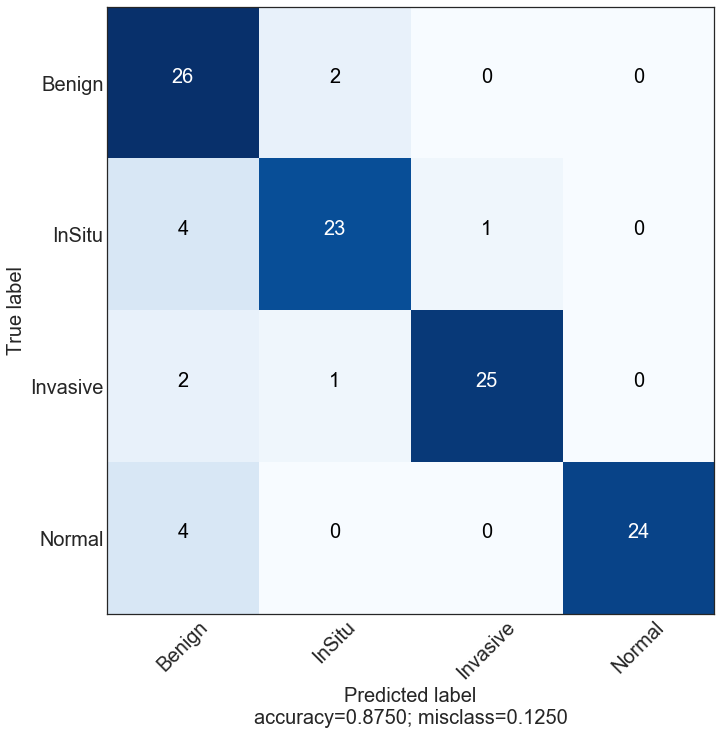

In [28]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[26  2  0  0]
 [ 4 23  1  0]
 [ 2  1 25  0]
 [ 4  0  0 24]]
              precision    recall  f1-score   support

      Benign       0.72      0.93      0.81        28
      Normal       0.88      0.82      0.85        28
      InSitu       0.96      0.89      0.93        28
    Invasive       1.00      0.86      0.92        28

   micro avg       0.88      0.88      0.88       112
   macro avg       0.89      0.88      0.88       112
weighted avg       0.89      0.88      0.88       112



In [30]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.66666666666667
Specificity :  92.0
